# Semantic and instance segmentation of images
This shows an example of a combined approach to doing _semantic_ and _instance_ segmentation of images. For this example of microscope slides containing lice, this means segmenting the image such that each segment represents a unique object (an _instance_) and that that object is from a particular (_semantic_) class. In the case of these slides, the classes are: background, specimens, labels, barcodes, and type labels

In [1]:
from pathlib import Path
import random

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import transforms

from segmentation.datasets import HerbariumSheets, ImageFolder, SemiSupervisedDataLoader
from segmentation.instances import DiscriminativeLoss, mean_shift, visualise_embeddings, visualise_instances
from segmentation.network import SemanticInstanceSegmentation
from segmentation.training import train

# Define model
The model is a neural network with two heads: one for the semantic class embeddings, and one for the instance embedding. A discriminative loss function is used that encourages embeddings from the same instance to be closer to each other than to an embedding from any other instance

In [2]:
model = SemanticInstanceSegmentation()
instance_clustering = DiscriminativeLoss()

# Load data

In [3]:
transform = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomCrop((1320, 872)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()])

target_transform = transforms.Compose([transform, transforms.Lambda(lambda x: (x * 255).long())])

batch_size = 3

# WARNING: Don't use multiple workers for loading! Doesn't work with setting random seed
train_data_labelled = HerbariumSheets(download=True, train=True, root='data', transform=transform, target_transform=target_transform)
train_loader_labelled = torch.utils.data.DataLoader(train_data_labelled, batch_size=batch_size, drop_last=True, shuffle=True)
train_data_unlabelled = ImageFolder(root='data/slides', transform=transform)
train_loader_unlabelled = torch.utils.data.DataLoader(train_data_unlabelled, batch_size=batch_size, drop_last=True, shuffle=True)
train_loader = SemiSupervisedDataLoader(train_loader_labelled, train_loader_unlabelled)

test_data_labelled = HerbariumSheets(download=True, train=False, root='data', transform=transform, target_transform=target_transform)
test_loader_labelled = torch.utils.data.DataLoader(test_data_labelled, batch_size=batch_size, drop_last=True, shuffle=True)
test_data_unlabelled = ImageFolder(root='data/slides', transform=transform)
test_loader_unlabelled = torch.utils.data.DataLoader(test_data_unlabelled, batch_size=batch_size, drop_last=True, shuffle=True)
test_loader = SemiSupervisedDataLoader(test_loader_labelled, test_loader_unlabelled)

# Train

In [4]:
#train(model, instance_clustering, train_loader, test_loader)

# Evaluate
Evaluates on test data, not on the training data

In [5]:
model.load_state_dict(torch.load('models/epoch_30'))
model.eval()

train_loader = torch.utils.data.DataLoader(test_data_labelled, batch_size=1, shuffle=False)

image, labels, instances = next(iter(train_loader))

image = Variable(image)
instances = Variable(instances + 1)
_, logits, instance_embeddings = model.forward_clean(image)

current_logits = logits[0]
current_labels = labels[0, 0]
current_instances = instances[0]

predicted_class = current_logits.data.max(0)[1]
predicted_instances = [None] * 5
for class_index in range(5):
    mask = predicted_class.view(-1) == class_index
    if mask.max() > 0:
        label_embedding = instance_embeddings[0].view(1, instance_embeddings.shape[1], -1)[..., mask]
        label_embedding = label_embedding.data.cpu().numpy()[0]

        predicted_instances[class_index] = mean_shift(label_embedding)

/home/scman1/.local/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/home/scman1/.local/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


### Visualise training results
Note that for _semantic_ segmentation the colours correspond to semantic classes, whereas for _instance_ segmentation the colours represent unique instances that can be in an arbitrary order - hence the ID number (colour) won't be the same as in the ground truth

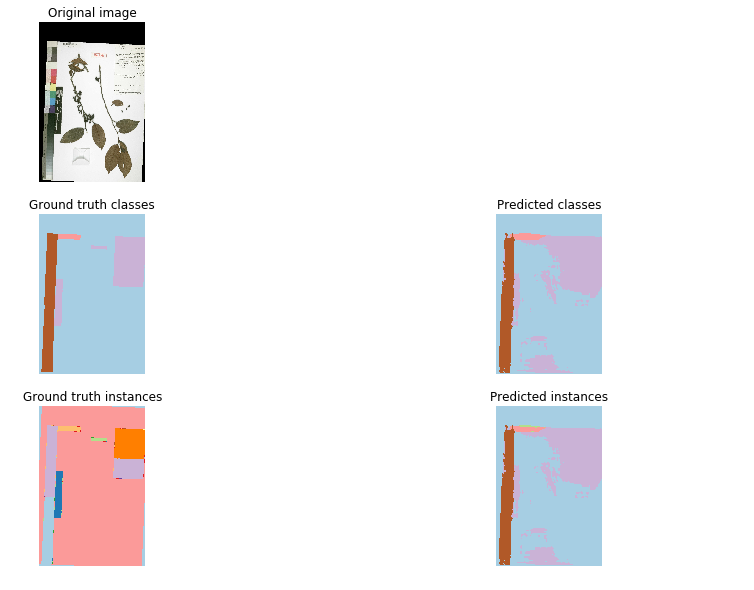

In [6]:
plt.rcParams['image.cmap'] = 'Paired'

fig, axes = plt.subplots(3, 2, figsize=(15, 10))
for ax in axes.flatten(): ax.axis('off')

axes[0, 0].set_title('Original image')
axes[0, 0].imshow(image[0].data.numpy().transpose(1, 2, 0))
axes[1, 0].set_title('Ground truth classes')
axes[1, 0].imshow(current_labels.cpu().numpy().squeeze())
axes[2, 0].set_title('Ground truth instances')
axes[2, 0].imshow(current_instances.cpu().numpy().squeeze())
axes[1, 1].set_title('Predicted classes')
axes[1, 1].imshow(predicted_class.cpu().numpy().squeeze())
instance_image = visualise_instances(predicted_instances, predicted_class, num_classes=5)
axes[2, 1].set_title('Predicted instances')
axes[2, 1].imshow(instance_image)

### Explicity clear memory on GPU
<small>Since all variables in the script are in the same scope, there is no garbage collection until reassignment. Need to get rid of derived data before running model subsequent times</small>

In [7]:
del (logits, instance_embeddings, instance_image, image, labels,
     instances, current_logits, current_labels, current_instances,
     mask, label_embedding, predicted_class, predicted_instances)

### Evaluate on full image
This evaluates on unlabelled data examples

In [9]:
filename = random.choice(list(Path('data', 'herbariumsheets').iterdir()))
image = torch.Tensor((plt.imread(filename) / 255).transpose(2, 0, 1)).unsqueeze(0)
_, logits, instance_embeddings = model.forward_clean(image)
predicted_class = logits[0].data.max(0)[1]
instance_embeddings = instance_embeddings[0]

predicted_instances = [None] * 5
for class_index in range(5):
    mask = predicted_class.view(-1) == class_index
    if mask.max() > 0:
       label_embedding = instance_embeddings.view(1, instance_embeddings.shape[0], -1)[..., mask]
       label_embedding = label_embedding.data.cpu().numpy()[0]

       predicted_instances[class_index] = mean_shift(label_embedding)

/home/scman1/.local/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/home/scman1/.local/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


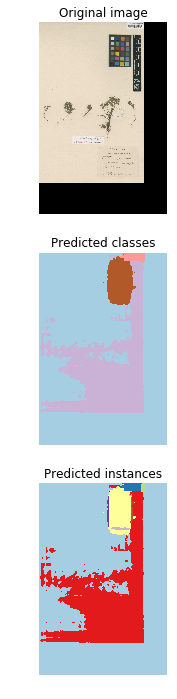

In [10]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12))
for ax in axes: ax.axis('off')

axes[0].set_title('Original image')
axes[0].imshow(image[0].numpy().transpose(1, 2, 0))

axes[1].set_title('Predicted classes')
axes[1].imshow(predicted_class.cpu().numpy())

axes[2].set_title('Predicted instances')
axes[2].imshow(visualise_instances(predicted_instances, predicted_class, num_classes=5))